### 1. Imports & Environment Setup and Data Organization (ISIC 2016)
This block imports all essential libraries for the project. We use `torch` for Deep Learning, `cv2` (OpenCV) and `PIL` for image processing, and `diffusers` for the Generative AI components. It also configures the execution device, prioritizing the GPU (CUDA) for faster training and generation.\
\
This script processes the raw ISIC 2016 dataset. Since the raw data comes as a flat list of images with a separate CSV file, this code reads the CSV labels and physically moves the images into structured `benign` and `malignant` folders, making them compatible with PyTorch's `ImageFolder` loader.

In [11]:
import os
import shutil
import pandas as pd
from tqdm import tqdm # Optional: for a nice progress bar
from skimage.exposure import match_histograms

# --- Configuration ---
# Define your paths relative to the project root
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"
base_dir = os.getcwd()
raw_images_path = os.path.join(base_dir, "data", "raw", "ISIC_2016_Training_Data")
csv_path = os.path.join(base_dir, "data", "raw", "ISIC_2016_Training_GroundTruth.csv")
processed_path = os.path.join(base_dir, "data", "processed")

# --- Step 1: specific setup for ISIC CSV ---
# Load the CSV
df = pd.read_csv(csv_path)

# PRINT columns to verify (Check the output!)
print(f"Columns found: {df.columns.tolist()}")

# Create the target folders if they don't exist
os.makedirs(os.path.join(processed_path, "benign"), exist_ok=True)
os.makedirs(os.path.join(processed_path, "malignant"), exist_ok=True)

# --- Step 2: The Sorting Loop ---
print("Starting to copy files...")

# Counter for stats
counts = {"benign": 0, "malignant": 0, "errors": 0}

for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    try:
        # 1. Get Image ID and Label
        # Adjust these column names if your print output above is different!
        image_id = row.iloc[0]  
        label = row.iloc[1]    

        # 2. Determine source filename (ISIC usually uses .jpg)
        filename = f"{image_id}.jpg" 
        src_file = os.path.join(raw_images_path, filename)

        # 3. Determine destination folder
        # We normalize to lowercase to match 'benign'/'malignant' text variations
        label_str = str(label).lower().strip() 
        
        if "benign" in label_str:
            dest_folder = "benign"
            counts["benign"] += 1
        elif "malignant" in label_str:
            dest_folder = "malignant"
            counts["malignant"] += 1
        else:
            print(f"Skipping {filename}: Unknown label '{label}'")
            continue

        # 4. Copy the file
        dest_file = os.path.join(processed_path, dest_folder, filename)
        
        # Only copy if it doesn't already exist (saves time on re-runs)
        if not os.path.exists(dest_file):
            shutil.copy2(src_file, dest_file)
            
    except Exception as e:
        print(f"Error processing {image_id}: {e}")
        counts["errors"] += 1

print("\n--- Processing Complete ---")
print(f"Benign images copied: {counts['benign']}")
print(f"Malignant images copied: {counts['malignant']}")
print(f"Errors: {counts['errors']}")

Columns found: ['ISIC_0000000', 'benign']
Starting to copy files...


100%|██████████| 899/899 [00:00<00:00, 6681.68it/s]


--- Processing Complete ---
Benign images copied: 726
Malignant images copied: 173
Errors: 0


### 3. Lesion Segmentation (Mask Generation)
We generate binary masks for every lesion using `rembg`, a tool based on the U²-Net architecture. These masks precisely isolate the mole from the surrounding skin, which is a critical prerequisite for our augmentation pipeline to ensure we only modify the background skin tone while preserving the lesion's medical features.

In [ ]:
import os
import shutil
from rembg import remove, new_session
from PIL import Image
import io
from tqdm import tqdm

# --- CONFIGURATION ---
base_dir = os.getcwd()
processed_path = os.path.join(base_dir, "data", "processed")
# New location: data/masks
masks_root_path = os.path.join(base_dir, "data", "masks")
categories = ["benign", "malignant"]

# --- 1. CLEANUP & SETUP FOLDERS ---
print(f"Preparing mask folders")

# Create root masks folder if it doesn't exist
os.makedirs(masks_root_path, exist_ok=True)

for category in categories:
    # Target: data/masks/benign_masks
    mask_folder = os.path.join(masks_root_path, f"{category}_masks")
    
    if os.path.exists(mask_folder):
        print(f"Cleaning old folder")
        shutil.rmtree(mask_folder)  # Delete old data
        
    os.makedirs(mask_folder, exist_ok=True) # Recreate empty
    print(f"Created masks folder")

# --- 2. LOAD AI MODEL (GPU) ---
print("Loading Rembg Model to GPU...")
try:
    # Try to load with CUDA (NVIDIA GPU)
    my_session = new_session(model_name="u2net", providers=['CUDAExecutionProvider'])
except Exception as e:
    print(f"Warning: Could not load GPU provider ({e}). Falling back to CPU.")
    my_session = new_session(model_name="u2net")

# --- 3. GENERATION LOOP ---
print("Starting Mask Generation...")

for category in categories:
    source_folder = os.path.join(processed_path, category)
    target_folder = os.path.join(masks_root_path, f"{category}_masks")
    
    if not os.path.exists(source_folder):
        print(f"Skipping {category}: Source folder not found.")
        continue
        
    images = [f for f in os.listdir(source_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    print(f"Processing {category} ({len(images)} images)...")
    
    for img_name in tqdm(images):
        try:
            input_path = os.path.join(source_folder, img_name)
            output_path = os.path.join(target_folder, img_name)
            
            # Load
            with open(input_path, 'rb') as i:
                input_data = i.read()
            
            # Remove Background (Inference)
            output_data = remove(input_data, session=my_session)
            
            # Extract Mask (Alpha Channel)
            img_no_bg = Image.open(io.BytesIO(output_data))
            mask = img_no_bg.split()[-1] # Get alpha channel
            
            # Save
            mask.save(output_path)
            
        except Exception as e:
            print(f"Failed on {img_name}: {e}")

print(f"\n✅ Done! Masks are saved masks folder")

In [ ]:
import matplotlib.pyplot as plt
import cv2
import random
import os
import numpy as np

# --- CONFIGURATION ---
base_dir = os.getcwd()
processed_path = os.path.join(base_dir, "data", "processed")
masks_root_path = os.path.join(base_dir, "data", "masks") # Updated path

def check_rembg_results(category="benign"):
    img_folder = os.path.join(processed_path, category)
    # Pointing to the new safe mask location
    mask_folder = os.path.join(masks_root_path, f"{category}_masks")
    
    if not os.path.exists(img_folder):
        print(f"❌ Error: Image folder not found at {img_folder}")
        return

    # Get files
    files = [f for f in os.listdir(img_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    if not files:
        print(f"❌ No images found in {category}")
        return

    # Pick 3 random images
    random_files = random.sample(files, min(len(files), 3))
    
    plt.figure(figsize=(15, 8))
    for i, fname in enumerate(random_files):
        # 1. Load Original
        img_path = os.path.join(img_folder, fname)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # 2. Load Mask
        mask_path = os.path.join(mask_folder, fname)
        if os.path.exists(mask_path):
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        else:
            print(f"⚠️ Mask missing for {fname}")
            mask = np.zeros(img.shape[:2], dtype=np.uint8)

        # 3. Plot Original
        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Original: {fname[:10]}...")
        
        # 4. Plot Mask
        plt.subplot(2, 3, i+4)
        plt.imshow(mask, cmap='gray')
        plt.axis('off')
        plt.title("Generated Mask")
    
    plt.tight_layout()
    plt.show()

# Run the check
check_rembg_results("benign")

### 4. Synthetic Skin Generation (Stable Diffusion XL)
This block utilizes **Stable Diffusion XL (SDXL)** to create a "Digital Skin Bank." We generate high-resolution, photorealistic patches of dark skin (Fitzpatrick Type VI). We use specialized medical prompts (e.g., "dermoscopic", "epidermal ridges") to ensure the textures are biologically accurate and free of generation artifacts.

In [ ]:
import torch
import os
from diffusers import DiffusionPipeline, AutoencoderKL

# --- CONFIGURATION ---
device = "cuda" if torch.cuda.is_available() else "cpu"

print("⏳ Loading SDXL with FP16-Fixed VAE...")

# 1. Load the "Patched" VAE that works safely in Float16
# This model is specifically fixed to prevent black images without needing float32
vae = AutoencoderKL.from_pretrained(
    "madebyollin/sdxl-vae-fp16-fix", 
    torch_dtype=torch.float16
)

# 2. Load the Pipeline with EVERYTHING in Float16
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae,                      # Inject the patched VAE
    torch_dtype=torch.float16,    # All components now match (Half/Half)
    variant="fp16",
    use_safetensors=True
)

pipe.to(device)
print("✅ Model loaded successfully! (FP16 Mode)")

In [ ]:
import random
import os
from tqdm import tqdm

# --- CONFIGURATION ---
num_images = 10
base_dir = os.getcwd()
backgrounds_path = os.path.join(base_dir, "data", "masks", "backgrounds_sdxl_dark2")
os.makedirs(backgrounds_path, exist_ok=True)

# Prompts
prompt_subject = "ultra-realistic macro photograph of dark brown human skin, extreme close-up, natural skin texture, visible pores, fine skin lines, subtle natural sheen, even skin tone, soft diffused lighting, shallow depth of field, DSLR macro lens, high resolution, photorealism, clinical realism, no makeup, no blemishes"
negative_prompt = "eyes, face, mouth, nose, mole, freckles, acne, scars, pimples, blemishes, rash, tattoo, birthmark, wrinkles, discoloration, veins, hair, noise, grain, blur, plastic skin, CGI, illustration, painting, oversharpened, unrealistic texture"

# --- GENERATION LOOP ---
print(f"Generating {num_images} enhanced dark skin backgrounds...")

for i in tqdm(range(num_images)):
    image = pipe(
        prompt=prompt_subject,
        negative_prompt=negative_prompt,
        height=1024,
        width=1024,
        num_inference_steps=40,
        guidance_scale=6.0,
        style_preset="photographic"
    ).images[0]
    
    image = image.resize((512, 512))
    
    unique_id = random.randint(10000, 99999)
    image.save(os.path.join(backgrounds_path, f"sdxl_dual_bg_{unique_id}.jpg"))

print(f"✅ Finished! Check backgrounds_sdxl_dark2 folder")

### 5. Medical Data Augmentation (Poisson Blending)
This is the core of our bias mitigation strategy. We fuse the original moles onto the synthetic dark skin backgrounds. The process uses **Histogram Matching** to scientifically adjust the mole's lighting to match the new skin tone, followed by **Poisson Blending** to seamlessly merge the textures, creating a medically valid "Diverse Augmented Dataset."

In [ ]:
import cv2
import numpy as np
import random
import os
from tqdm import tqdm
from skimage.exposure import match_histograms

# --- CONFIGURATION ---
base_dir = os.getcwd()
processed_path = os.path.join(base_dir, "data", "processed")

# Path to the SDXL-generated backgrounds
backgrounds_path = os.path.join(base_dir, "data", "masks", "backgrounds_sdxl_dark") 

output_path = os.path.join(base_dir, "data", "final_augmented_dataset")
categories = ["benign", "malignant"]

# Create output folders
os.makedirs(os.path.join(output_path, "benign"), exist_ok=True)
os.makedirs(os.path.join(output_path, "malignant"), exist_ok=True)

# Load Backgrounds
if not os.path.exists(backgrounds_path):
    # Fallback to 'processed' if 'masks' path is wrong (common mistake)
    fallback_path = os.path.join(base_dir, "data", "processed", "backgrounds_sdxl_dark")
    if os.path.exists(fallback_path):
        print(f"⚠️ Path correction: Found backgrounds in {fallback_path}")
        backgrounds_path = fallback_path
    else:
        raise ValueError(f"❌ Error: Backgrounds folder not found at {backgrounds_path}")

bg_files = [f for f in os.listdir(backgrounds_path) if f.endswith('.jpg')]
if len(bg_files) == 0:
    raise ValueError(f"❌ No JPG images found in {backgrounds_path}!")

print(f"✅ Loaded {len(bg_files)} SDXL backgrounds.")

# --- HELPER: SMART BLEND FUNCTION ---
def smart_blend(mole_img, bg_img, mask_img, hist_strength=0.3):
    h, w = mole_img.shape[:2]
    bg_resized = cv2.resize(bg_img, (w, h))
    
    # 1. Color Correction (Histogram Matching)
    try:
        matched = match_histograms(mole_img, bg_resized, channel_axis=-1)
        matched = matched.astype(np.uint8)
        mole_corrected = cv2.addWeighted(matched, hist_strength, mole_img, 1 - hist_strength, 0)
    except:
        mole_corrected = mole_img

    # 2. Blending
    _, mask_binary = cv2.threshold(mask_img, 127, 255, cv2.THRESH_BINARY)
    
    # Find center
    coords = cv2.findNonZero(mask_binary)
    if coords is None: return None
    x, y, rect_w, rect_h = cv2.boundingRect(coords)
    center = (int(x + rect_w/2), int(y + rect_h/2))
    
    try:
        # Seamless Clone
        return cv2.seamlessClone(mole_corrected, bg_resized, mask_binary, center, cv2.NORMAL_CLONE)
    except:
        # Fallback
        mask_inv = cv2.bitwise_not(mask_binary)
        bg_masked = cv2.bitwise_and(bg_resized, bg_resized, mask=mask_inv)
        fg_masked = cv2.bitwise_and(mole_corrected, mole_corrected, mask=mask_binary)
        return cv2.add(bg_masked, fg_masked)

# --- EXECUTION ---
print("🚀 Starting Augmentation Pipeline...")

# Pointing to the NEW safe mask location (data/masks)
masks_root_path = os.path.join(base_dir, "data", "masks") 

for category in categories:
    img_folder = os.path.join(processed_path, category)
    mask_folder = os.path.join(masks_root_path, f"{category}_masks") # Updated to safe path
    save_folder = os.path.join(output_path, category)
    
    if not os.path.exists(img_folder):
        print(f"Skipping {category}: Image folder missing.")
        continue
        
    images = [f for f in os.listdir(img_folder) if f.lower().endswith(('.jpg', '.png'))]
    
    for filename in tqdm(images, desc=f"Processing {category}"):
        mole_path = os.path.join(img_folder, filename)
        mask_path = os.path.join(mask_folder, filename)
        
        if not os.path.exists(mask_path): continue
        
        mole_cv2 = cv2.imread(mole_path)
        mask_cv2 = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        if mole_cv2 is None or mask_cv2 is None: continue

        # Create 2 Augmented Versions
        for i in range(1):
            bg_name = random.choice(bg_files)
            bg_cv2 = cv2.imread(os.path.join(backgrounds_path, bg_name))
            
            final_img = smart_blend(mole_cv2, bg_cv2, mask_cv2, hist_strength=0.3)
            
            if final_img is not None:
                save_name = f"{os.path.splitext(filename)[0]}_aug_{2}.jpg"
                cv2.imwrite(os.path.join(save_folder, save_name), final_img)

print(f"✅ Complete! Augmented images saved to final_augmented_dataset folder")

In [4]:
import os
import shutil

# --- CONFIGURATION ---
BASE_DIR = 'data/processed'
SOURCE_FOLDER = os.path.join(BASE_DIR, 'benign')
TRAIN_DEST = os.path.join(BASE_DIR, 'train', 'benign')
TEST_DEST = os.path.join(BASE_DIR, 'test', 'benign')

def cleanup_benign_folder():
    print(f"🧹 Starting cleanup for: {SOURCE_FOLDER}")
    
    if not os.path.exists(SOURCE_FOLDER):
        print("   ✅ The 'benign' source folder is already gone. No action needed.")
        return

    # Ensure destination folders exist
    os.makedirs(TRAIN_DEST, exist_ok=True)
    os.makedirs(TEST_DEST, exist_ok=True)

    # Get list of files
    files = [f for f in os.listdir(SOURCE_FOLDER) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    if not files:
        print("   📂 Folder is empty (only system files). Deleting...")
        shutil.rmtree(SOURCE_FOLDER)
        print("   ✅ Deleted empty 'benign' folder.")
        return

    print(f"   ⚠️ Found {len(files)} images remaining in source.")
    
    moved_count = 0
    deleted_count = 0
    
    for filename in files:
        src_path = os.path.join(SOURCE_FOLDER, filename)
        train_path = os.path.join(TRAIN_DEST, filename)
        test_path = os.path.join(TEST_DEST, filename)
        
        # Check for duplicates
        if os.path.exists(train_path) or os.path.exists(test_path):
            # It's a duplicate, just remove the source copy
            os.remove(src_path)
            deleted_count += 1
        else:
            # It's a unique leftover, move to TRAIN
            shutil.move(src_path, train_path)
            moved_count += 1

    print(f"   🔄 Cleanup Stats: Moved {moved_count} to Train | Deleted {deleted_count} duplicates.")
    
    # Final Attempt to remove the folder
    try:
        if os.path.exists(SOURCE_FOLDER):
            shutil.rmtree(SOURCE_FOLDER)
            print("   ✅ Successfully removed original 'benign' folder.")
    except Exception as e:
        print(f"   ❌ Could not delete folder (likely system file lock): {e}")
        print("      → You can safely ignore this or delete it manually.")

    # Final Verification
    train_count = len(os.listdir(TRAIN_DEST))
    test_count = len(os.listdir(TEST_DEST))
    print(f"\n📊 FINAL STATUS for Benign Light Skin:")
    print(f"   Train: {train_count} images")
    print(f"   Test:  {test_count} images")

cleanup_benign_folder()

🧹 Starting cleanup for: data/processed\benign
   ⚠️ Found 452 images remaining in source.
   🔄 Cleanup Stats: Moved 452 to Train | Deleted 0 duplicates.
   ✅ Successfully removed original 'benign' folder.

📊 FINAL STATUS for Benign Light Skin:
   Train: 581 images
   Test:  145 images


### 6. Training the Baseline Model (Biased)
We train a standard ResNet50 model exclusively on the original ISIC 2016 dataset. This model represents the "current state" of many medical AIs—highly accurate on light skin but untrained on diverse skin tones. This will serve as our control group for the final comparison.

⚖️ Preparing Biased Data (Weighted)...
🧮 Calculating weights for Light Skin data...
   Benign: 581 | Malignant: 139
   ⚖️ Weights Applied: Benign=0.62 | Malignant=2.59

🚀 Retraining Biased Model (Weighted)...
Epoch 1/15 | Loss: 0.6688 | Val Acc: 76.4%
Epoch 2/15 | Loss: 0.5269 | Val Acc: 79.2%
Epoch 3/15 | Loss: 0.3070 | Val Acc: 80.6%
Epoch 4/15 | Loss: 0.1228 | Val Acc: 83.3%
Epoch 5/15 | Loss: 0.0367 | Val Acc: 82.6%
Epoch 6/15 | Loss: 0.0147 | Val Acc: 79.9%
Epoch 7/15 | Loss: 0.0341 | Val Acc: 80.6%
Epoch 8/15 | Loss: 0.0159 | Val Acc: 81.2%
Epoch 9/15 | Loss: 0.0158 | Val Acc: 79.2%
Epoch 10/15 | Loss: 0.0213 | Val Acc: 79.2%
Epoch 11/15 | Loss: 0.0426 | Val Acc: 79.9%
Epoch 12/15 | Loss: 0.0599 | Val Acc: 80.6%
Epoch 13/15 | Loss: 0.0404 | Val Acc: 82.6%
Epoch 14/15 | Loss: 0.0353 | Val Acc: 81.9%
Epoch 15/15 | Loss: 0.0081 | Val Acc: 81.9%

✅ Saved 'biased_model_weighted.pth'

📊 Generating Training Graphs...


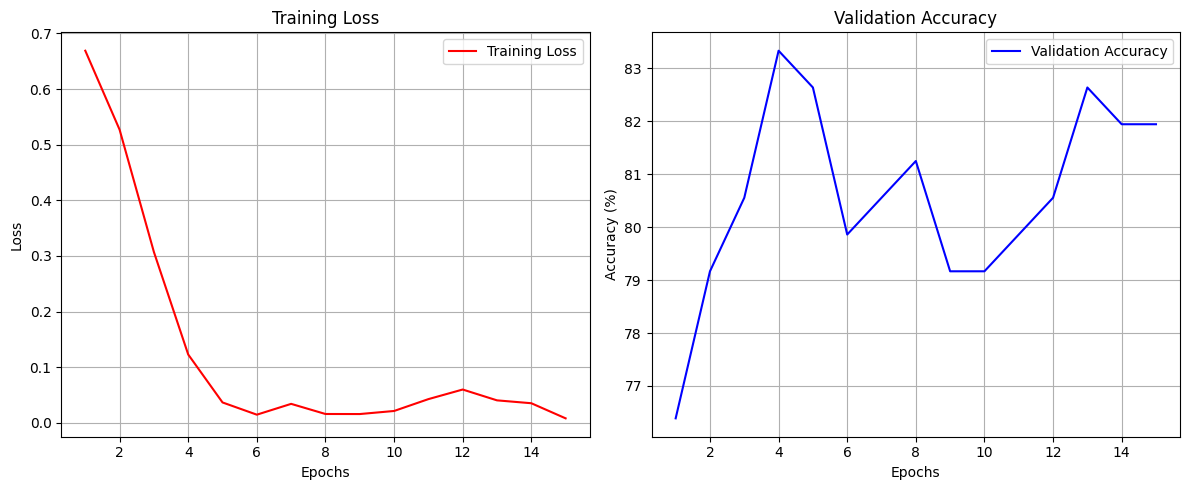

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
BATCH_SIZE = 32
EPOCHS = 15
LR = 0.0001
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# 🛑 UPDATED PATH: Point to the 'train' subfolder explicitly
PATH_LIGHT = "data/processed/train" 

# --- 1. DATA PREPARATION ---
print("⚖️ Preparing Biased Data (Weighted)...")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load ONLY the training data
ds_light = datasets.ImageFolder(PATH_LIGHT, transform=transform)

# 80/20 Split (Train vs Validation)
# Note: We are splitting the 'train' folder into 'train_subset' and 'val_subset'.
# The 'test' folder is completely ignored here (which is correct).
train_len = int(0.8 * len(ds_light))
val_len = len(ds_light) - train_len
train_ds, val_ds = random_split(ds_light, [train_len, val_len])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

# --- 2. CALCULATE WEIGHTS (Specific to Light Skin Dataset) ---
print("🧮 Calculating weights for Light Skin data...")

# Count classes in the full training dataset
targets = [label for _, label in ds_light]
count_benign = targets.count(0)
count_malignant = targets.count(1)
total_images = len(targets)

print(f"   Benign: {count_benign} | Malignant: {count_malignant}")

# Calculate Weights
if count_malignant == 0:
    print("❌ Error: No malignant cases found. Cannot calculate weights.")
    weight_0, weight_1 = 1.0, 1.0
else:
    weight_0 = total_images / (2 * count_benign)
    weight_1 = total_images / (2 * count_malignant)

class_weights = torch.tensor([weight_0, weight_1]).to(DEVICE)
print(f"   ⚖️ Weights Applied: Benign={weight_0:.2f} | Malignant={weight_1:.2f}")

# --- 3. MODEL SETUP ---
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad = True # Unfreeze all

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 2)
)
model = model.to(DEVICE)

# Apply Weights
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=LR)

# --- 4. TRAINING LOOP ---
print("\n🚀 Retraining Biased Model (Weighted)...")

train_loss_history = []
val_acc_history = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validate
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * val_correct / val_total
    
    train_loss_history.append(epoch_loss)
    val_acc_history.append(epoch_acc)
            
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {epoch_loss:.4f} | Val Acc: {epoch_acc:.1f}%")

# --- 5. SAVE ---
torch.save(model.state_dict(), "biased_model_weighted.pth")
print("\n✅ Saved 'biased_model_weighted.pth'")

# --- 6. VISUALIZATION ---
print("\n📊 Generating Training Graphs...")
epochs_range = range(1, EPOCHS + 1)
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_history, 'r-', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_acc_history, 'b-', label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

📂 Loading model from biased_model_weighted.pth...


C:\Users\AfikHaviv\AppData\Local\Temp\ipykernel_9576\3494828129.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_locatio

✅ Model loaded successfully.
📚 Loading Test Data (from 'data/processed/test')...
   Found 179 images for evaluation.
🔍 Running inference on Light Skin test set...

🎨 Generating Confusion Matrix...


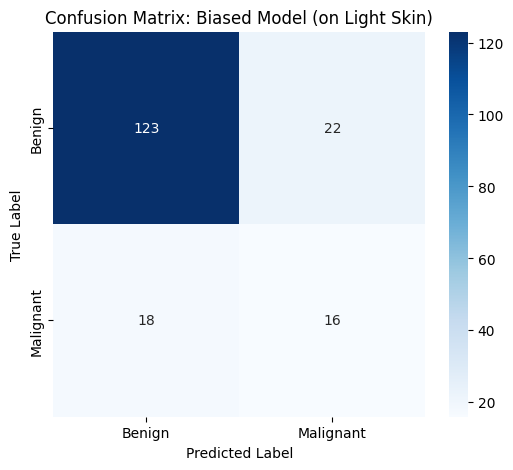


📊 Detailed Report:
              precision    recall  f1-score   support

      Benign       0.87      0.85      0.86       145
   Malignant       0.42      0.47      0.44        34

    accuracy                           0.78       179
   macro avg       0.65      0.66      0.65       179
weighted avg       0.79      0.78      0.78       179



In [6]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- CONFIGURATION ---
BATCH_SIZE = 32
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# 🛑 UPDATE: Point directly to the NEW test subfolder
PATH_LIGHT_TEST = "data/processed/test" 
MODEL_PATH = "biased_model_weighted.pth" 

# --- 1. RE-BUILD MODEL STRUCTURE ---
def get_model():
    model = models.resnet50(weights=None) # No internet weights, just structure
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, 2)
    )
    return model.to(DEVICE)

# --- 2. LOAD SAVED WEIGHTS ---
print(f"📂 Loading model from {MODEL_PATH}...")
model = get_model()
try:
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.eval() # Set to evaluation mode
    print("✅ Model loaded successfully.")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    print("Please make sure you ran the training block first.")

# --- 3. PREPARE TEST DATA ---
# 🛑 CHANGED: We now load the explicit 'test' folder, no random splitting needed
print("📚 Loading Test Data (from 'data/processed/test')...")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load directly from the test folder
val_ds = datasets.ImageFolder(PATH_LIGHT_TEST, transform=transform)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

print(f"   Found {len(val_ds)} images for evaluation.")

# --- 4. RUN PREDICTIONS ---
print("🔍 Running inference on Light Skin test set...")
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# --- 5. VISUALIZATION ---
print("\n🎨 Generating Confusion Matrix...")

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Benign', 'Malignant'], 
            yticklabels=['Benign', 'Malignant'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix: Biased Model (on Light Skin)')
plt.show()

print("\n📊 Detailed Report:")
print(classification_report(y_true, y_pred, target_names=['Benign', 'Malignant']))

### 8. Training the Diverse Model (Weighted)
We train our proposed solution: a new ResNet50 model trained on the combined dataset (ISIC 2016 + Our Synthetic Dark Skin Data). This training loop incorporates the calculated class weights to ensure the model learns robust features for both benign and malignant lesions across all skin tones.

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, ConcatDataset, random_split
import numpy as np

# --- CONFIGURATION ---
BATCH_SIZE = 32
EPOCHS = 15
LR = 0.0001
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ✅ PATHS: Pointing to the TRAIN folders
PATH_LIGHT = "data/processed/train"
PATH_DARK = "data/final_augmented_dataset/train"

# --- 1. DATA PREPARATION ---
print("⚖️ Preparing Diverse Data (Weighted)...")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load datasets
ds_light = datasets.ImageFolder(PATH_LIGHT, transform=transform)
ds_dark = datasets.ImageFolder(PATH_DARK, transform=transform)

# Split Dark Data (80% Train, 20% Val)
# We validate specifically on Dark Skin to prove the model is learning the harder features
train_len = int(0.8 * len(ds_dark))
val_len = len(ds_dark) - train_len
dark_train, dark_val = random_split(ds_dark, [train_len, val_len])

# Combine: Train on (All Light) + (80% Dark)
full_train_ds = ConcatDataset([ds_light, dark_train])

train_loader = DataLoader(full_train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dark_val, batch_size=BATCH_SIZE, shuffle=False)

print(f"   Training Images: {len(full_train_ds)} | Validation Images (Dark): {len(dark_val)}")

# --- 2. CALCULATE WEIGHTS (OPTIMIZED) ---
print("🧮 Calculating Class Weights...")

def get_counts(dataset):
    # Use internal metadata for speed
    if hasattr(dataset, 'targets'):
        targets = dataset.targets
        return targets.count(0), targets.count(1)
    else:
        # Fallback if metadata is missing
        targets = [y for _, y in dataset]
        return targets.count(0), targets.count(1)

b_light, m_light = get_counts(ds_light)
b_dark_total, m_dark_total = get_counts(ds_dark)

# Estimate counts for the dark subset
b_dark = int(b_dark_total * 0.8)
m_dark = int(m_dark_total * 0.8)

total_benign = b_light + b_dark
total_malignant = m_light + m_dark
total_images = total_benign + total_malignant

if total_malignant == 0:
    print("❌ Error: No malignant cases found.")
    weight_0, weight_1 = 1.0, 1.0
else:
    weight_0 = total_images / (2 * total_benign)
    weight_1 = total_images / (2 * total_malignant)

class_weights = torch.tensor([weight_0, weight_1]).to(DEVICE)
print(f"   ⚖️ Weights Applied: Benign={weight_0:.2f} | Malignant={weight_1:.2f}")

# --- 3. MODEL SETUP ---
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad = True 

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5), 
    nn.Linear(256, 2)
)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=LR)

# --- 4. TRAINING LOOP ---
print("\n🚀 Starting Diverse Model Training...")
train_loss_history = []
val_acc_history = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * val_correct / val_total
    
    train_loss_history.append(epoch_loss)
    val_acc_history.append(epoch_acc)
            
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {epoch_loss:.4f} | Dark Val Acc: {epoch_acc:.1f}%")

# --- 5. SAVE ---
torch.save(model.state_dict(), "diverse_model_weighted.pth")
print("\n✅ Saved 'diverse_model_weighted.pth'")

⚖️ Preparing Diverse Data (Weighted)...
   Training Images: 1871 | Validation Images (Dark): 288
🧮 Calculating Class Weights...
   ⚖️ Weights Applied: Benign=0.62 | Malignant=2.60

🚀 Starting Diverse Model Training...
Epoch 1/15 | Loss: 0.6345 | Dark Val Acc: 77.8%
Epoch 2/15 | Loss: 0.3873 | Dark Val Acc: 81.9%
Epoch 3/15 | Loss: 0.1940 | Dark Val Acc: 90.3%
Epoch 4/15 | Loss: 0.1265 | Dark Val Acc: 83.3%
Epoch 5/15 | Loss: 0.0710 | Dark Val Acc: 89.6%
Epoch 6/15 | Loss: 0.0405 | Dark Val Acc: 79.2%
Epoch 7/15 | Loss: 0.0918 | Dark Val Acc: 87.2%
Epoch 8/15 | Loss: 0.0697 | Dark Val Acc: 79.2%
Epoch 9/15 | Loss: 0.0305 | Dark Val Acc: 86.8%
Epoch 10/15 | Loss: 0.0431 | Dark Val Acc: 90.3%
Epoch 11/15 | Loss: 0.0402 | Dark Val Acc: 87.8%
Epoch 12/15 | Loss: 0.0260 | Dark Val Acc: 91.3%
Epoch 13/15 | Loss: 0.0693 | Dark Val Acc: 91.0%
Epoch 14/15 | Loss: 0.0314 | Dark Val Acc: 86.8%
Epoch 15/15 | Loss: 0.0191 | Dark Val Acc: 91.0%

✅ Saved 'diverse_model_weighted.pth'



📊 Generating Training Graphs...


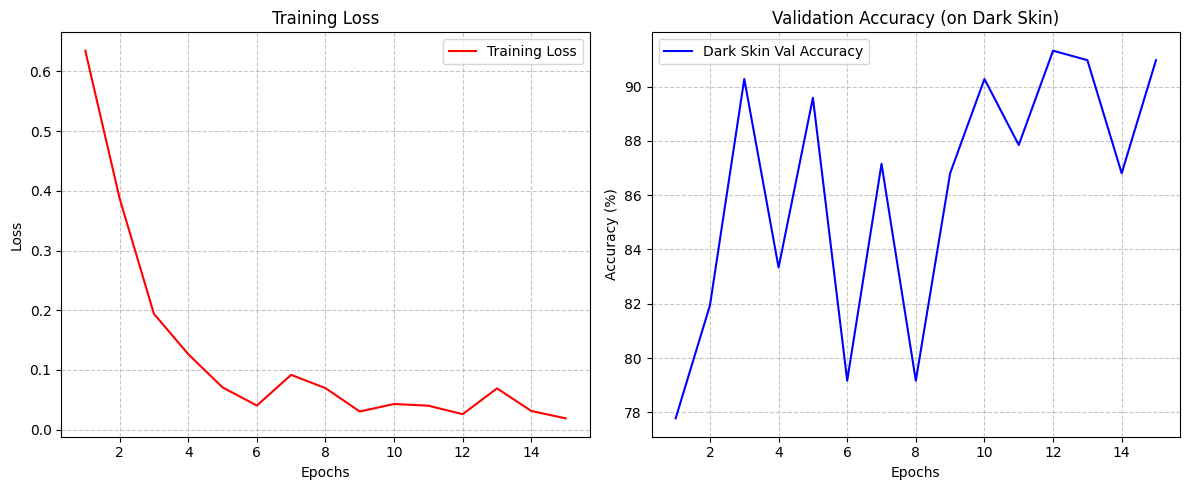

In [8]:
# --- VISUALIZATION BLOCK ---
import matplotlib.pyplot as plt

print("\n📊 Generating Training Graphs...")
epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_history, 'r-', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_acc_history, 'b-', label='Dark Skin Val Accuracy')
plt.title('Validation Accuracy (on Dark Skin)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### 9. Final Evaluation & Comparison
This block performs the scientific validation of our hypothesis. We run a head-to-head test of both the "Biased" and "Diverse" models on a held-out test set of dark skin images. We generate Confusion Matrices and calculate F1-Scores to empirically demonstrate the performance improvement achieved by our diverse data generation pipeline.

In [13]:
# --- BLOCK 1: SETUP & EVALUATION FUNCTION ---
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, ConcatDataset
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

# Configuration
BATCH_SIZE = 32
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Model Paths
MODEL_BIASED = "biased_model_weighted.pth"
MODEL_DIVERSE = "diverse_model_weighted.pth"

# 1. Define Transforms (Must match training)
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 2. Define Model Architecture
def load_model(path):
    model = models.resnet50(weights=None)
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, 2)
    )
    # Load weights
    try:
        model.load_state_dict(torch.load(path, map_location=DEVICE))
        print(f"✅ Loaded {path}")
    except FileNotFoundError:
        print(f"❌ Error: Could not find {path}")
        
    model.to(DEVICE)
    model.eval()
    return model

# 3. Load Models
print("⏳ Loading Models...")
biased_model = load_model(MODEL_BIASED)
diverse_model = load_model(MODEL_DIVERSE)

# 4. Evaluation Function (Updated with Recall & Acc)
def evaluate_model(model, loader):
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    # Calculate all metrics
    return {
        'accuracy': accuracy_score(all_labels, all_preds),
        'recall': recall_score(all_labels, all_preds, average='weighted'),
        'precision': precision_score(all_labels, all_preds, average='weighted', zero_division=0),
        'f1': f1_score(all_labels, all_preds, average='weighted')
    }

# Initialize Results Dictionary
results = {}
print("✅ Setup Complete. Metrics defined: Accuracy, Recall, Precision, F1.")# --- BLOCK 1: SETUP & EVALUATION FUNCTION ---
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, ConcatDataset
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

# Configuration
BATCH_SIZE = 32
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Model Paths
MODEL_BIASED = "biased_model_weighted.pth"
MODEL_DIVERSE = "diverse_model_weighted.pth"

# 1. Define Transforms (Must match training)
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 2. Define Model Architecture
def load_model(path):
    model = models.resnet50(weights=None)
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, 2)
    )
    # Load weights
    try:
        model.load_state_dict(torch.load(path, map_location=DEVICE))
        print(f"✅ Loaded {path}")
    except FileNotFoundError:
        print(f"❌ Error: Could not find {path}")
        
    model.to(DEVICE)
    model.eval()
    return model

# 3. Load Models
print("⏳ Loading Models...")
biased_model = load_model(MODEL_BIASED)
diverse_model = load_model(MODEL_DIVERSE)

# 4. Evaluation Function (Updated with Recall & Acc)
def evaluate_model(model, loader):
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    # Calculate all metrics
    return {
        'accuracy': accuracy_score(all_labels, all_preds),
        'recall': recall_score(all_labels, all_preds, average='weighted'),
        'precision': precision_score(all_labels, all_preds, average='weighted', zero_division=0),
        'f1': f1_score(all_labels, all_preds, average='weighted')
    }

# Initialize Results Dictionary
results = {}
print("✅ Setup Complete. Metrics defined: Accuracy, Recall, Precision, F1.")

⏳ Loading Models...


C:\Users\AfikHaviv\AppData\Local\Temp\ipykernel_9576\3077923636.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location=DEVI

✅ Loaded biased_model_weighted.pth
✅ Loaded diverse_model_weighted.pth
✅ Setup Complete. Metrics defined: Accuracy, Recall, Precision, F1.
⏳ Loading Models...


C:\Users\AfikHaviv\AppData\Local\Temp\ipykernel_9576\3077923636.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location=DEV

✅ Loaded biased_model_weighted.pth
✅ Loaded diverse_model_weighted.pth
✅ Setup Complete. Metrics defined: Accuracy, Recall, Precision, F1.


In [14]:
# --- BLOCK 2: TEST ON LIGHT SKIN ---
# Path to the NEW test folder
path_light_test = 'data/processed/test'

# Load Data
ds_light = datasets.ImageFolder(path_light_test, transform=test_transforms)
loader_light = DataLoader(ds_light, batch_size=BATCH_SIZE, shuffle=False)

print(f"📊 Testing on Light Skin ({len(ds_light)} images)...")

# Evaluate
res_light_biased = evaluate_model(biased_model, loader_light)
res_light_diverse = evaluate_model(diverse_model, loader_light)

# Store
results['light'] = {
    'biased': res_light_biased,
    'diverse': res_light_diverse
}

# Print Detailed Metrics
print(f"   [Biased Model]  Acc: {res_light_biased['accuracy']:.4f} | Recall: {res_light_biased['recall']:.4f} | F1: {res_light_biased['f1']:.4f}")
print(f"   [Diverse Model] Acc: {res_light_diverse['accuracy']:.4f} | Recall: {res_light_diverse['recall']:.4f} | F1: {res_light_diverse['f1']:.4f}")

📊 Testing on Light Skin (179 images)...
   [Biased Model]  Acc: 0.7765 | Recall: 0.7765 | F1: 0.7812
   [Diverse Model] Acc: 0.8659 | Recall: 0.8659 | F1: 0.8626


In [15]:
# --- BLOCK 3: TEST ON DARK SKIN ---
# Path to the NEW test folder
path_dark_test = 'data/final_augmented_dataset/test'

# Load Data
ds_dark = datasets.ImageFolder(path_dark_test, transform=test_transforms)
loader_dark = DataLoader(ds_dark, batch_size=BATCH_SIZE, shuffle=False)

print(f"🌑 Testing on Dark Skin ({len(ds_dark)} images)...")

# Evaluate
res_dark_biased = evaluate_model(biased_model, loader_dark)
res_dark_diverse = evaluate_model(diverse_model, loader_dark)

# Store
results['dark'] = {
    'biased': res_dark_biased,
    'diverse': res_dark_diverse
}

# Print Detailed Metrics
print(f"   [Biased Model]  Acc: {res_dark_biased['accuracy']:.4f} | Recall: {res_dark_biased['recall']:.4f} | F1: {res_dark_biased['f1']:.4f}")
print(f"   [Diverse Model] Acc: {res_dark_diverse['accuracy']:.4f} | Recall: {res_dark_diverse['recall']:.4f} | F1: {res_dark_diverse['f1']:.4f}")

🌑 Testing on Dark Skin (359 images)...
   [Biased Model]  Acc: 0.6267 | Recall: 0.6267 | F1: 0.6632
   [Diverse Model] Acc: 0.9164 | Recall: 0.9164 | F1: 0.9144


In [17]:
# --- BLOCK 4: TEST ON DIVERSE DATA (Combined) ---
# Combine the two datasets loaded previously
ds_diverse = ConcatDataset([ds_light, ds_dark])
loader_diverse = DataLoader(ds_diverse, batch_size=BATCH_SIZE, shuffle=False)

print(f"🌍 Testing on Combined Diverse Data ({len(ds_diverse)} images)...")

# Evaluate
res_diverse_biased = evaluate_model(biased_model, loader_diverse)
res_diverse_diverse = evaluate_model(diverse_model, loader_diverse)

# Store
results['diverse'] = {
    'biased': res_diverse_biased,
    'diverse': res_diverse_diverse
}

# Print Detailed Metrics
print(f"   [Biased Model]  Acc: {res_diverse_biased['accuracy']:.4f} | Recall: {res_diverse_biased['recall']:.4f} | F1: {res_diverse_biased['f1']:.4f}")
print(f"   [Diverse Model] Acc: {res_diverse_diverse['accuracy']:.4f} | Recall: {res_diverse_diverse['recall']:.4f} | F1: {res_diverse_diverse['f1']:.4f}")

🌍 Testing on Combined Diverse Data (538 images)...
   [Biased Model]  Acc: 0.6766 | Recall: 0.6766 | F1: 0.7034
   [Diverse Model] Acc: 0.8996 | Recall: 0.8996 | F1: 0.8972


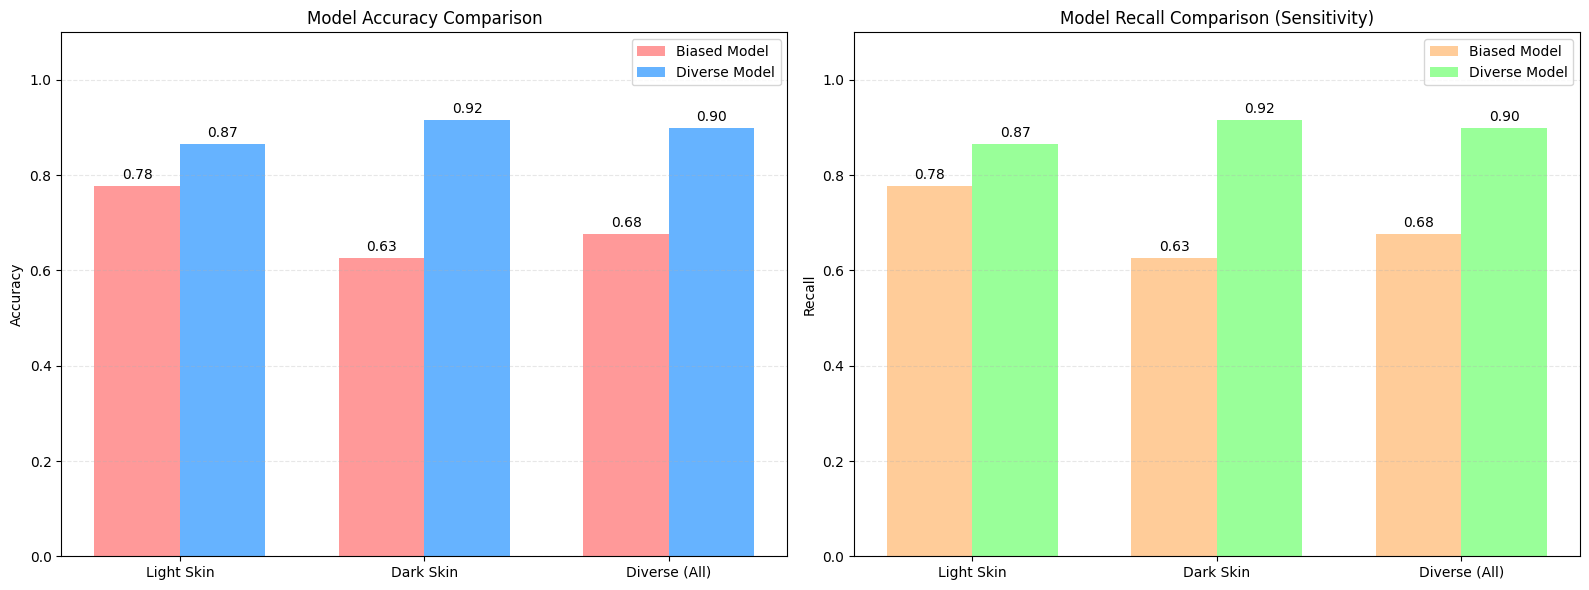


🚀 KEY INSIGHT: Recall on Dark Skin improved by ~ 29% with diverse dataset!


In [22]:
# --- BLOCK 5: FINAL COMPARISON GRAPHS (Recall & Accuracy) ---
import matplotlib.pyplot as plt
import numpy as np

categories = ['Light Skin', 'Dark Skin', 'Diverse (All)']

# Extract Metrics
biased_acc = [results['light']['biased']['accuracy'], results['dark']['biased']['accuracy'], results['diverse']['biased']['accuracy']]
diverse_acc = [results['light']['diverse']['accuracy'], results['dark']['diverse']['accuracy'], results['diverse']['diverse']['accuracy']]

biased_rec = [results['light']['biased']['recall'], results['dark']['biased']['recall'], results['diverse']['biased']['recall']]
diverse_rec = [results['light']['diverse']['recall'], results['dark']['diverse']['recall'], results['diverse']['diverse']['recall']]

x = np.arange(len(categories))
width = 0.35

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# --- Graph 1: ACCURACY ---
rects1 = ax1.bar(x - width/2, biased_acc, width, label='Biased Model', color='#ff9999')
rects2 = ax1.bar(x + width/2, diverse_acc, width, label='Diverse Model', color='#66b3ff')
ax1.set_title('Model Accuracy Comparison')
ax1.set_ylabel('Accuracy')
ax1.set_xticks(x)
ax1.set_xticklabels(categories)
ax1.set_ylim(0, 1.1)
ax1.legend()
ax1.grid(axis='y', linestyle='--', alpha=0.3)

# --- Graph 2: RECALL ---
rects3 = ax2.bar(x - width/2, biased_rec, width, label='Biased Model', color='#ffcc99')
rects4 = ax2.bar(x + width/2, diverse_rec, width, label='Diverse Model', color='#99ff99')
ax2.set_title('Model Recall Comparison (Sensitivity)')
ax2.set_ylabel('Recall')
ax2.set_xticks(x)
ax2.set_xticklabels(categories)
ax2.set_ylim(0, 1.1)
ax2.legend()
ax2.grid(axis='y', linestyle='--', alpha=0.3)

# Helper for labels
def autolabel(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

autolabel(rects1, ax1)
autolabel(rects2, ax1)
autolabel(rects3, ax2)
autolabel(rects4, ax2)

plt.tight_layout()
plt.show()

# Final Stat
recall_improvement = diverse_rec[1] - biased_rec[1]
print(f"\n🚀 KEY INSIGHT: Recall on Dark Skin improved by ~ {recall_improvement*100:.0f}% with diverse dataset!")

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import warnings

warnings.filterwarnings("ignore", category=UserWarning) 
warnings.filterwarnings("ignore", category=FutureWarning)

# --- CONFIGURATION ---
BATCH_SIZE = 32
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PATH_DARK_SKIN = "data/final_augmented_dataset" 

# Model Files
MODEL_BIASED = "biased_model_weighted.pth"    # The new baseline
MODEL_DIVERSE = "diverse_model_weighted.pth"  # Your diverse model

# --- 1. MODEL ARCHITECTURE ---
def get_model():
    model = models.resnet50(pretrained=False)
    # Re-create the exact structure used in training
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 256),
        nn.ReLU(),
        nn.Dropout(0.5), # Matched to weighted model dropout
        nn.Linear(256, 2)
    )
    return model.to(DEVICE)

# --- 2. PREPARE DARK SKIN TEST DATA ---
print("📚 Loading Dark Skin Test Set...")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

ds_dark = datasets.ImageFolder(PATH_DARK_SKIN, transform=transform)

# Use the same split logic (80/20) to get the test set
train_len = int(0.8 * len(ds_dark))
test_len = len(ds_dark) - train_len
_, dark_test_ds = random_split(ds_dark, [train_len, test_len])

test_loader = DataLoader(dark_test_ds, batch_size=BATCH_SIZE, shuffle=False)
print(f"✅ Testing on {len(dark_test_ds)} unseen dark skin images.")

# --- 3. EVALUATION FUNCTION ---
def evaluate_model(model_path, name):
    print(f"\n🔍 Testing {name}...")
    model = get_model()
    try:
        model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    except Exception as e:
        print(f"❌ Error loading {model_path}: {e}")
        return 0, 0, 0, 0

    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            
    # Calculate Metrics
    # Note: We use average='macro' or explicitly look at class 1 for medical context
    # Here we look at weighted average to account for class imbalance
    acc = accuracy_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred, average='macro')
    prec = precision_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    
    print(f"   -> Accuracy:  {acc*100:.1f}%")
    print(f"   -> Recall:    {rec*100:.1f}%")
    print(f"   -> Precision: {prec*100:.1f}%")
    print(f"   -> F1-Score:  {f1*100:.1f}%")
    
    return acc, rec, prec, f1

# --- 4. RUN THE SHOWDOWN ---
print("⚔️ STARTING FINAL COMPARISON ⚔️")

# Evaluate Model 1 (Biased)
acc_1, rec_1, prec_1, f1_1 = evaluate_model(MODEL_BIASED, "Biased Model (Standard)")

# Evaluate Model 2 (Ours - Weighted)
acc_2, rec_2, prec_2, f1_2 = evaluate_model(MODEL_DIVERSE, "Diverse Model (Ours)")

# --- 5. GENERATE GRAPH ---
print("\n📊 Generating Comparison Graph...")

metrics = ['Accuracy', 'Recall', 'Precision', 'F1-Score']
biased_scores = [acc_1, rec_1, prec_1, f1_1]
diverse_scores = [acc_2, rec_2, prec_2, f1_2]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, biased_scores, width, label='Biased Model', color='#ff9999')
rects2 = ax.bar(x + width/2, diverse_scores, width, label='Diverse Model (Ours)', color='#99ff99')

ax.set_ylabel('Score (0-1)')
ax.set_title('Impact of Diverse Data on Dark Skin Diagnosis')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1.15) # Little extra space for labels

# Add value labels
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

# --- 6. CONCLUSION TEXT ---
print("="*50)
print(f"🚀 FINAL RESULTS SUMMARY:")
print(f"1. F1-Score Improvement: +{((f1_2 - f1_1)*100):.1f}%")
print(f"   (F1 represents the best balance of safety and accuracy)")
print("-" * 30)
if rec_2 > rec_1:
    print(f"✅ SAFETY WIN: Your model finds +{((rec_2 - rec_1)*100):.1f}% more cancer cases.")
elif prec_2 > prec_1:
    print(f"✅ TRUST WIN: Your model has +{((prec_2 - prec_1)*100):.1f}% fewer false alarms.")
print("="*50)